In [51]:
from google.colab import drive
drive.mount('/content/drive')
BATCH_SIZE = 128
CROP_SIZE = 60
TRAIN_DIR = "/content/drive/MyDrive/dataset/train/"
TEST_DIR = "/content/drive/MyDrive/dataset/test/"
OUTDIR = "model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
pip install jcopdl

In [53]:
from torch import nn
from jcopdl.layers import conv_block, linear_block

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # conv_block(3, 8),
            # conv_block(8, 16),
            conv_block(3, 16),
            conv_block(16, 32),
            # conv_block(3, 32),
            # conv_block(32, 64),            
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            # linear_block(16*15*15, 240, dropout=0.1),
            # linear_block(240, 3, activation="lsoftmax")
            linear_block(32*15*15, 480, dropout=0.1),
            linear_block(480, 3, activation="lsoftmax")
            # linear_block(64*15*15, 960, dropout=0.1),
            # linear_block(960, 3, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(self.conv(x))

In [54]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    # gambar1, normal
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))




Epoch     1
Train_cost  = 1.1010 | Test_cost  = 1.0951 | Train_score = 0.3333 | Test_score = 0.3333 |




Epoch     2
Train_cost  = 1.1034 | Test_cost  = 1.0823 | Train_score = 0.3333 | Test_score = 0.5000 |




Epoch     3
Train_cost  = 1.0697 | Test_cost  = 1.0613 | Train_score = 0.4444 | Test_score = 0.5000 |
==> EarlyStop patience =  1 | Best test_score: 0.5000




Epoch     4
Train_cost  = 1.0284 | Test_cost  = 1.0171 | Train_score = 0.4444 | Test_score = 0.3333 |
==> EarlyStop patience =  2 | Best test_score: 0.5000




Epoch     5
Train_cost  = 1.0139 | Test_cost  = 0.9941 | Train_score = 0.5556 | Test_score = 0.3333 |
==> EarlyStop patience =  3 | Best test_score: 0.5000




Epoch     6
Train_cost  = 0.9643 | Test_cost  = 0.9543 | Train_score = 0.5556 | Test_score = 0.8333 |




Epoch     7
Train_cost  = 0.8778 | Test_cost  = 0.9174 | Train_score = 0.8889 | Test_score = 0.8333 |
==> EarlyStop patience =  1 | Best test_score: 0.8333




Epoch     8
Train_cost  = 0.8609 | Test_cost  = 0.8637 | Train_score = 0.7778 | Test_score = 0.8333 |
==> EarlyStop patience =  2 | Best test_score: 0.8333




Epoch     9
Train_cost  = 0.8091 | Test_cost  = 0.8126 | Train_score = 0.8333 | Test_score = 1.0000 |




Epoch    10
Train_cost  = 0.7622 | Test_cost  = 0.7504 | Train_score = 0.9444 | Test_score = 1.0000 |
==> EarlyStop patience =  1 | Best test_score: 1.0000




Epoch    11
Train_cost  = 0.6996 | Test_cost  = 0.6941 | Train_score = 0.7222 | Test_score = 0.8333 |
==> EarlyStop patience =  2 | Best test_score: 1.0000




Epoch    12
Train_cost  = 0.6605 | Test_cost  = 0.6152 | Train_score = 0.8333 | Test_score = 0.8333 |
==> EarlyStop patience =  3 | Best test_score: 1.0000




Epoch    13
Train_cost  = 0.6411 | Test_cost  = 0.5568 | Train_score = 0.8889 | Test_score = 1.0000 |
==> EarlyStop patience =  4 | Best test_score: 1.0000




Epoch    14
Train_cost  = 0.6461 | Test_cost  = 0.6054 | Train_score = 0.7222 | Test_score = 0.6667 |
==> EarlyStop patience =  5 | Best test_score: 1.0000
==> Execute Early Stopping at epoch: 14 | Best test_score: 1.0000
==> Best model is saved at model


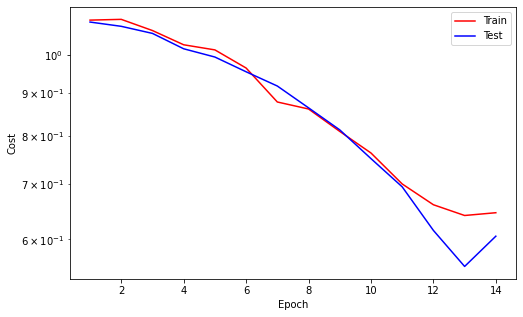

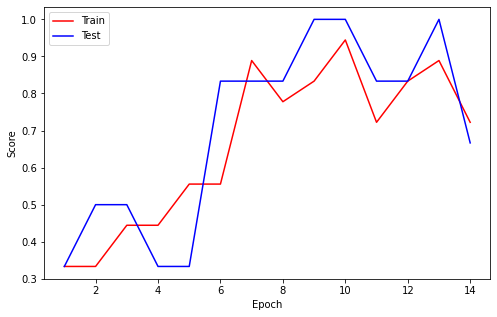

In [55]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# def train():
    # Dataset & Dataloader
train_transform = transforms.Compose([
    # transforms.RandomRotation(15),
    transforms.RandomResizedCrop(CROP_SIZE, scale=(0.8, 1.0)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(CROP_SIZE),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder(TEST_DIR, transform=test_transform)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

label2cat = train_set.classes
label2cat

# Config
config = set_config({
    "batch_size": BATCH_SIZE,
    "crop_size": CROP_SIZE
})

# Training Preparation
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir=OUTDIR)

# Training
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Callbacks
    callback.log(train_cost, test_cost, train_score, test_score)
    callback.save_checkpoint()
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break
            
# if __name__ == "__main__":
#     train()

In [56]:
label2cat

['abnormal', 'normal', 'normal 3 lapis']

In [57]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [58]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([2, 1, 0, 1, 2, 0])

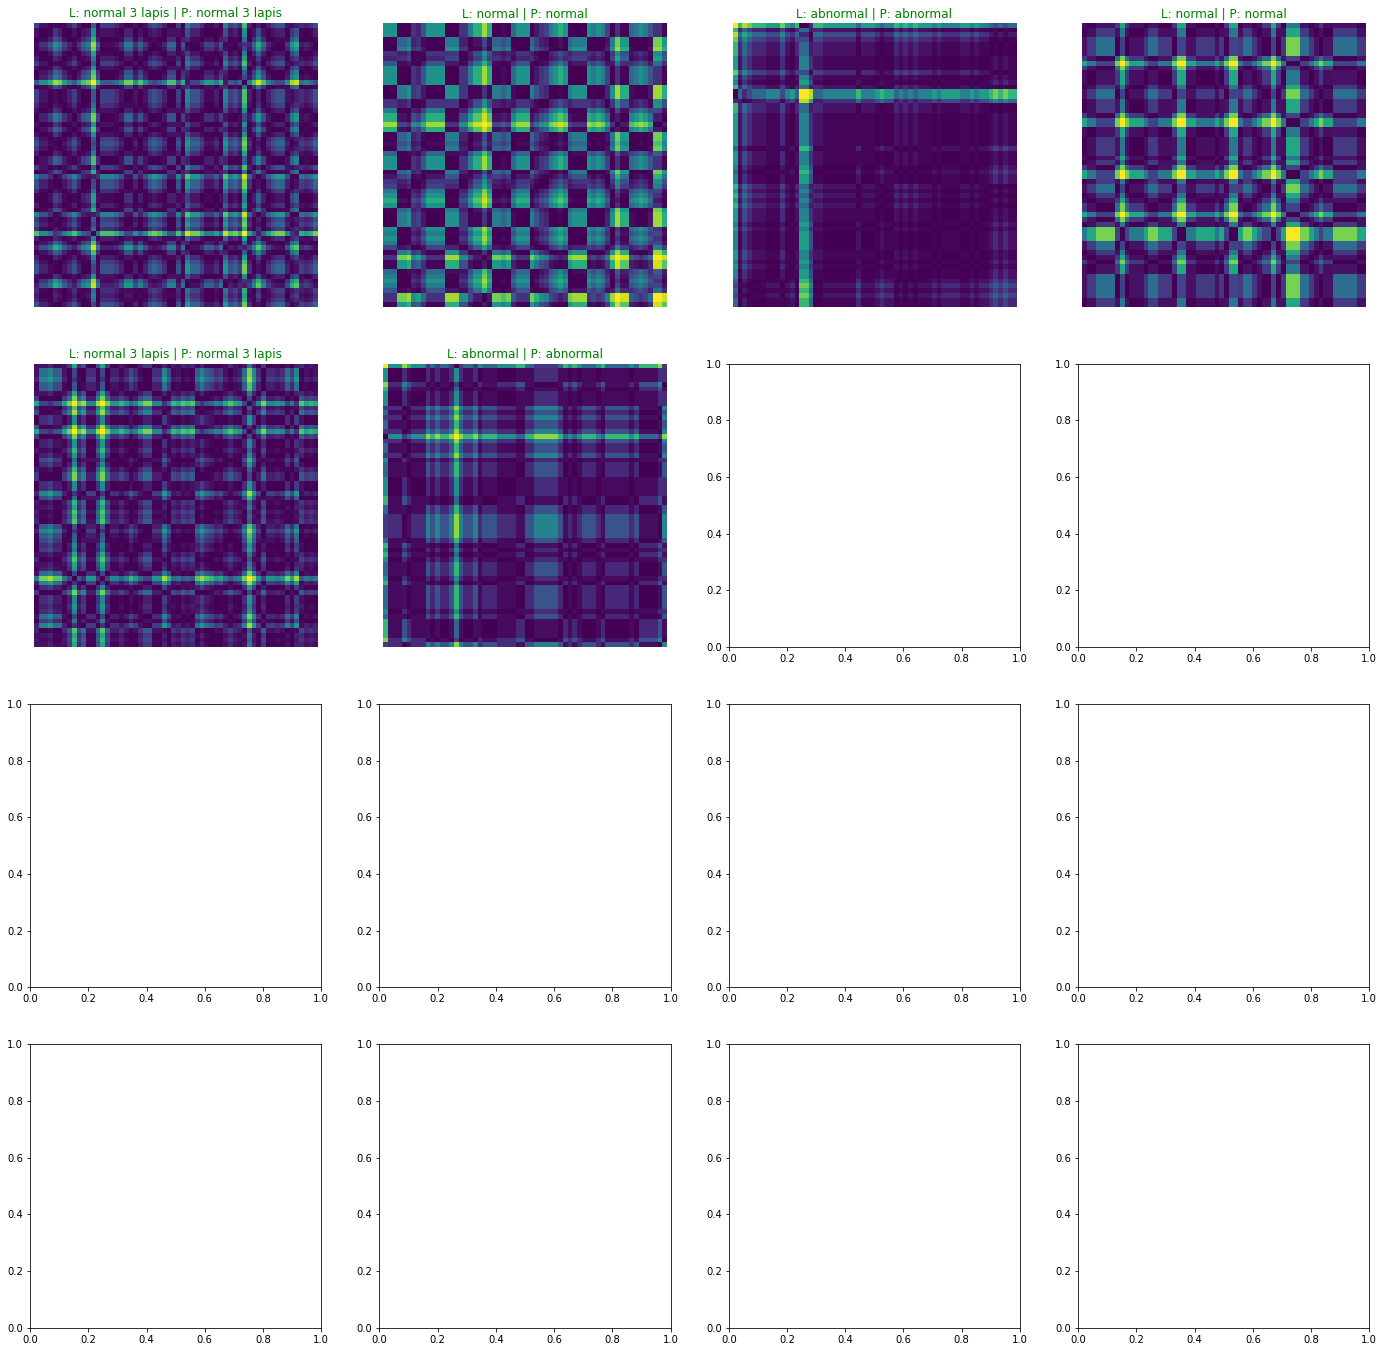

In [59]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4,4,figsize=(24,24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(image.permute(1,2,0).cpu())
  font = {'color':'r'} if label != pred else {'color':'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"L: {label} | P: {pred}", fontdict=font)
  ax.axis("off");

In [60]:
# f, z = next(iter(testloader))
# f, z = f.to(device), z.to(device)
# with torch.no_grad():
#     model.eval()
#     output = model(f)
#     preds = output.argmax(1)
# print(preds)
# plt.imshow(f[1][1])
# print(f[3][1])
# # plt.imshow(f[2][3])
# fig, axes = plt.subplots(4,4,figsize=(24,24))
# for im, label, ax in zip(f, z, axes.flatten()):
#   # print(im.shape)
#   ax.imshow(im.permute(1,2,0).cpu())
#   ax.axis("off");